<font size="6">**Nathan GALMICHE and Victor PIRIOU**</font>

<font size="5">**1.2 Data visualisation**</font>

In [1]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
from PIL import Image,ImageDraw
from skimage.transform import resize
import numpy as np
import cv2

11/12

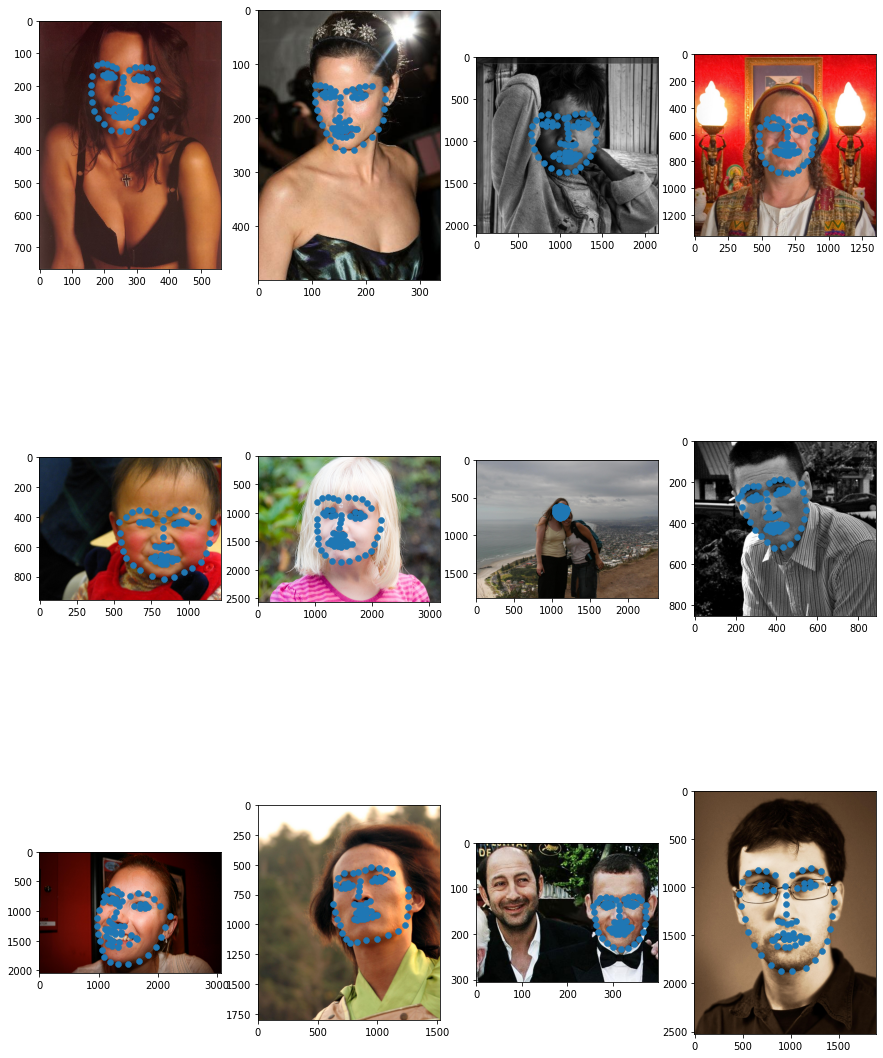

In [2]:
with open('300w_train_images.txt') as f:
    train_img_path = [line.rstrip('\n') for line in f]
    
with open('300w_train_landmarks.txt') as f:
    train_landmark_paths = [line.rstrip('\n') for line in f]
    
with open('helen_testset.txt') as f:
    test_img_path = [line.rstrip('\n') for line in f]
    
with open('helen_testset_landmarks.txt') as f:
    test_landmark_paths = [line.rstrip('\n') for line in f]

fig = figure(figsize = (15, 20))

selected_indices = np.random.choice(len(train_img_path), 12)

train_img_path = np.array(train_img_path)

for i,line in enumerate(train_img_path[selected_indices]):
    print("\r" + str(i) + "/" + str(len(train_img_path[selected_indices])),end='')
    
    pts = np.loadtxt(train_landmark_paths[selected_indices[i]])

    img = mpimg.imread(line)
    
    ax = fig.add_subplot(3,4,i+1)
    
    ax.scatter(pts[:,0],pts[:,1],linewidths=0.5)
    ax.imshow(img)

<font size="5">**1.3 Data augmentation**</font>

In [3]:
import os

nb_selected_img = 1000

In [4]:
# this cell doesn't need to be re-executed

for i,landmark in enumerate(train_landmark_paths):
    if(i == nb_selected_img):
        break
    
    print("\r" + str(i+1) + "/" + str(min(len(train_landmark_paths),nb_selected_img)),end='')
    
    img = mpimg.imread(train_img_path[i])
    
    pts = np.loadtxt(landmark)
    xmin = pts[:,0].min()
    xmax = pts[:,0].max()
    ymin = pts[:,1].min()
    ymax = pts[:,1].max()
    
    w = xmax-xmin
    h = ymax-ymin
    
    # widening of the bounding box
    xmin_exp = int(xmin-w*0.15)
    xmax_exp = int(xmax+w*0.15)
    ymin_exp = int(ymin-h*0.15)
    ymax_exp = int(ymax+h*0.15)

    # the bounding box should not extend beyond the image
    if xmin_exp < 0:
        xmin_exp = 0
    if xmax_exp >= len(img[0]):
        xmax_exp = len(img[0])-1
    if ymin_exp < 0:
        ymin_exp = 0
    if ymax_exp >= len(img):
        ymax_exp = len(img)-1

    img = img[ymin_exp:ymax_exp, xmin_exp:xmax_exp]
    
    h = len(img)
    w = len(img[0])
    
    img = resize(img,(128,128))
    
    newpts = []
    for pt in pts:
        newpt = str((pt[0]-xmin_exp)/w*128) + ' ' + str((pt[1]-ymin_exp)/h*128)
        newpts.append(newpt)
        
    if(not os.path.exists("helen/preprocessed_train_img")):
        os.mkdir("helen/preprocessed_train_img")
        
    with open('helen/preprocessed_train_img/figure'+str(i)+'.txt', 'w') as f:
        newpts = '\n'.join(newpts)
        f.write(newpts)
    
    plt.imsave('helen/preprocessed_train_img/figure'+str(i)+'.png', img)

1000/1000

In [5]:
# this cell doesn't need to be re-executed

for i,landmark in enumerate(test_landmark_paths):
    print("\r" + str(i+1) + "/" + str(len(test_landmark_paths)),end='')
    
    img = mpimg.imread(test_img_path[i])
    
    pts = np.loadtxt(landmark)
    xmin = pts[:,0].min()
    xmax = pts[:,0].max()
    ymin = pts[:,1].min()
    ymax = pts[:,1].max()
    
    w = xmax-xmin
    h = ymax-ymin
    
    # widening of the bounding box
    xmin_exp = int(xmin-w*0.15)
    xmax_exp = int(xmax+w*0.15)
    ymin_exp = int(ymin-h*0.15)
    ymax_exp = int(ymax+h*0.15)

    # the bounding box should not extend beyond the image
    if xmin_exp < 0:
        xmin_exp = 0
    if xmax_exp >= len(img[0]):
        xmax_exp = len(img[0])-1
    if ymin_exp < 0:
        ymin_exp = 0
    if ymax_exp >= len(img):
        ymax_exp = len(img)-1

    img = img[ymin_exp:ymax_exp, xmin_exp:xmax_exp]
    
    h = len(img)
    w = len(img[0])
    
    img = resize(img,(128,128))
    
    newpts = []
    for pt in pts:
        newpt = str((pt[0]-xmin_exp)/w*128) + ' ' + str((pt[1]-ymin_exp)/h*128)
        newpts.append(newpt)
        
    if(not os.path.exists("helen/preprocessed_test_img")):
        os.mkdir("helen/preprocessed_test_img")
        
    with open('helen/preprocessed_test_img/figure'+str(i)+'.txt', 'w') as f:
        newpts = '\n'.join(newpts)
        f.write(newpts)
    
    plt.imsave('helen/preprocessed_test_img/figure'+str(i)+'.png', img)

330/330

<font size="3">**Check that the preprocess went well:**</font>

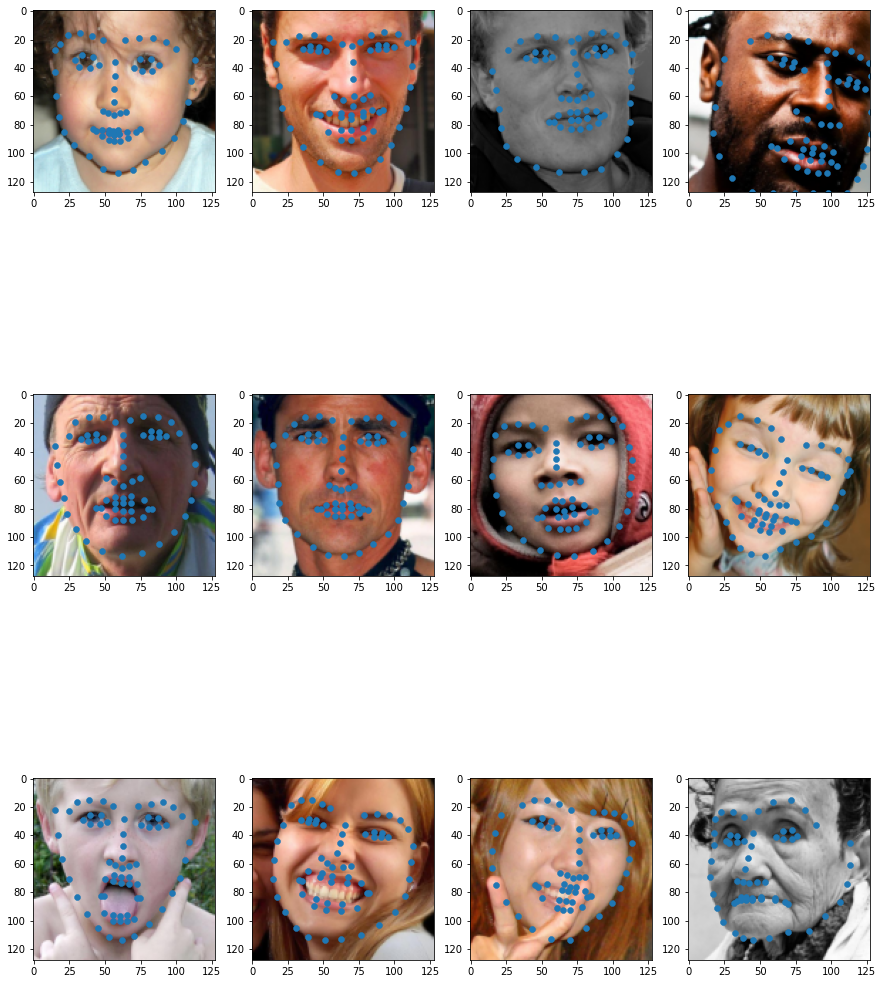

In [6]:
# this cell doesn't need to be re-executed

fig = figure(figsize = (15, 20))

selected_indices = np.random.choice(nb_selected_img, 12)

cpt = 0

for i in selected_indices:
    pts = np.loadtxt('helen/preprocessed_train_img/figure'+str(i)+'.txt')
    img = mpimg.imread('helen/preprocessed_train_img/figure'+str(i)+'.png')
    
    ax = fig.add_subplot(3,4,cpt+1)
    
    ax.scatter(pts[:,0],pts[:,1],linewidths=0.5)
    ax.imshow(img)
    
    cpt += 1

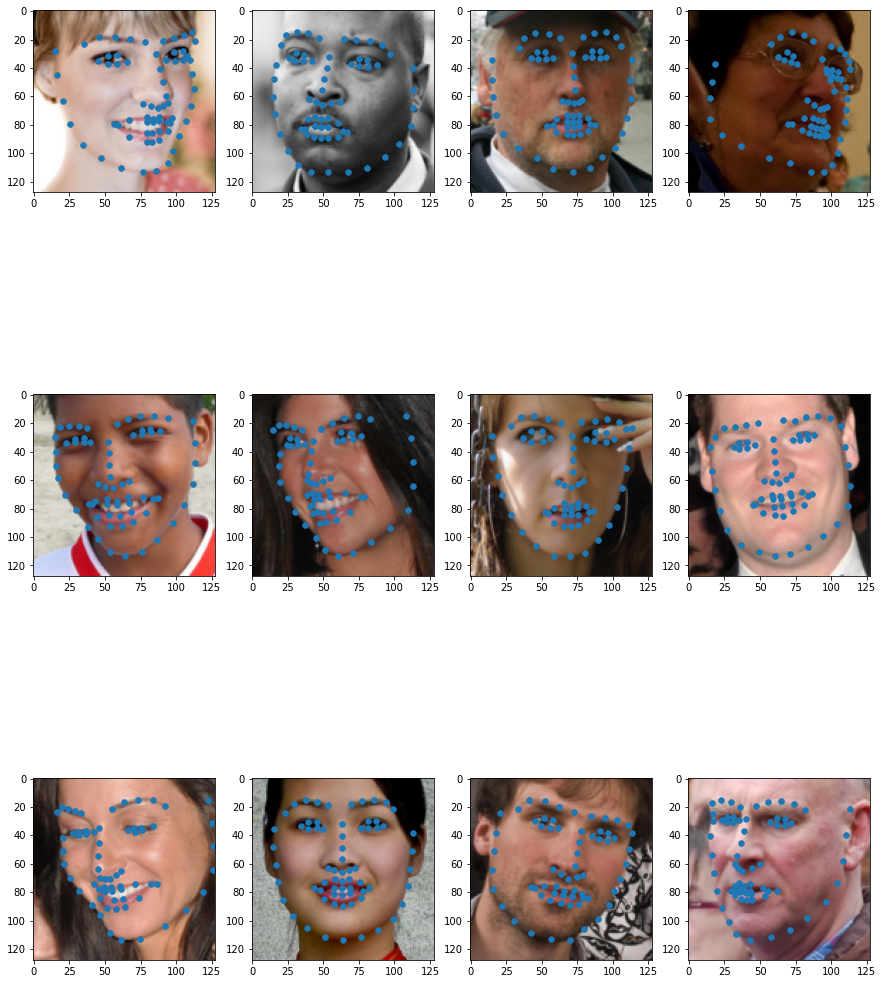

In [7]:
# this cell doesn't need to be re-executed

fig = figure(figsize = (15, 20))

selected_indices = np.random.choice(len(test_landmark_paths), 12)

cpt = 0

for i in selected_indices:
    pts = np.loadtxt('helen/preprocessed_test_img/figure'+str(i)+'.txt')
    img = mpimg.imread('helen/preprocessed_test_img/figure'+str(i)+'.png')
    
    ax = fig.add_subplot(3,4,cpt+1)
    
    ax.scatter(pts[:,0],pts[:,1],linewidths=0.5)
    ax.imshow(img)
    
    cpt += 1

train:


test:


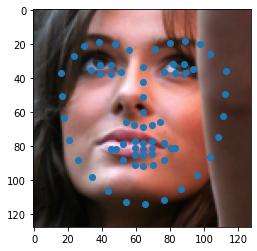

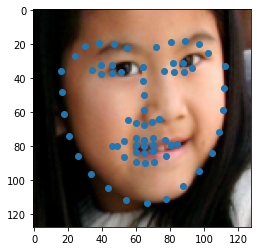

In [8]:
import pickle

def compute_mean_landmarks(dataset_type):
    if(dataset_type == "train"):
        mean = np.loadtxt('helen/preprocessed_train_img/figure'+str(0)+'.txt')
    elif(dataset_type == "test"):
        mean = np.loadtxt('helen/preprocessed_test_img/figure'+str(0)+'.txt')
    
    if(dataset_type == "train"):
        for i in range(1,min(len(train_landmark_paths),nb_selected_img)):
            print("\r" + str(i) + "/" + str(min(len(train_landmark_paths),nb_selected_img)),end='')
            
            pts = np.loadtxt('helen/preprocessed_train_img/figure' + str(i) + '.txt')

            mean[:,0] += pts[:,0]
            mean[:,1] += pts[:,1]
            
        mean[:,0] = [x/min(len(train_landmark_paths),nb_selected_img) for x in mean[:,0]]
        mean[:,1] = [y/min(len(train_landmark_paths),nb_selected_img) for y in mean[:,1]]
    elif(dataset_type == "test"):
        for i in range(1,len(test_landmark_paths)):
            print("\r" + str(i) + "/" + str(len(test_landmark_paths)),end='')
            
            pts = np.loadtxt('helen/preprocessed_test_img/figure' + str(i) + '.txt')

            mean[:,0] += pts[:,0]
            mean[:,1] += pts[:,1]
        
        mean[:,0] = [x/len(test_landmark_paths) for x in mean[:,0]]
        mean[:,1] = [y/len(test_landmark_paths) for y in mean[:,1]]
    
    return mean

print("train:")

if(os.path.exists('backup')):
    if(not os.path.exists('backup/mean_train_landmarks.pkl')):
        mean_train_landmarks = compute_mean_landmarks("train")

        with open('backup/mean_train_landmarks.pkl', 'wb') as file:
            pickle.dump(mean_train_landmarks, file)
    else:
        with open('backup/mean_train_landmarks.pkl', 'rb') as file:
            mean_train_landmarks = pickle.load(file)
else:
    os.mkdir("backup")
    
    mean_train_landmarks = compute_mean_landmarks("train")

    with open('backup/mean_train_landmarks.pkl', 'wb') as file:
        pickle.dump(mean_train_landmarks, file)
        
print("\n\ntest:")
        
if(not os.path.exists('backup/mean_test_landmarks.pkl')):
    mean_test_landmarks = compute_mean_landmarks("test")

    with open('backup/mean_test_landmarks.pkl', 'wb') as file:
        pickle.dump(mean_test_landmarks, file)
else:
    with open('backup/mean_test_landmarks.pkl', 'rb') as file:
        mean_test_landmarks = pickle.load(file)
    
plt.imshow(mpimg.imread('helen/preprocessed_train_img/figure0.png'))
plt.scatter(np.array(mean_train_landmarks)[:,0],np.array(mean_train_landmarks)[:,1])
plt.show()    

plt.imshow(mpimg.imread('helen/preprocessed_test_img/figure0.png'))
plt.scatter(np.array(mean_test_landmarks)[:,0],np.array(mean_test_landmarks)[:,1])
plt.show()    

<font size="3">**5. Why do we generate these perturbations? How could they be estimated automatically?**</font>

We generate these perturbations to match the variety of faces we can encounter. Also, pictures of faces can be taken from more or less far and with varying angles. The perturbations are data augmentations 

In [9]:
# this cell doesn't need to be re-executed

for i in range(min(len(train_landmark_paths),nb_selected_img)):
    print("\r" + str(i+1) + "/" + str(min(len(train_landmark_paths),nb_selected_img)),end='')
    
    img = mpimg.imread('helen/preprocessed_train_img/figure'+str(i)+'.png')
    for j in range(10):
        newPts = mean_train_landmarks.copy()
        
        tx=np.random.randint(-20,20)
        ty=np.random.randint(-20,20)
        sx=np.random.randint(-20,20)/100
        sy=np.random.randint(-20,20)/100
        
        # apply the random perturbation
        newPts[:,0] = newPts[:,0]*(1+sx)+tx
        newPts[:,1] = newPts[:,1]*(1+sy)+ty
        
        perturb = []
        
        for pt in newPts:
            if pt[0] < 0:
                pt[0] = 0
            elif pt[0] > 128:
                pt[0] = 128
            if pt[1] < 0:
                pt[1] = 0
            elif pt[1] > 128:
                pt[1] = 128
                
            perturb.append(str(pt[0])+' '+str(pt[1]))
        
        with open('helen/preprocessed_train_img/figure'+str(i)+'_'+str(j)+'.txt', 'w') as f:
            perturb = '\n'.join(perturb)
            f.write(perturb)   

1000/1000

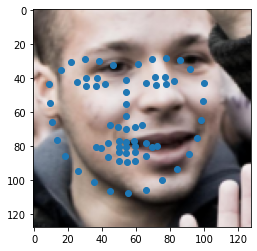

In [10]:
# this cell doesn't need to be re-executed

plt.imshow(mpimg.imread('helen/preprocessed_train_img/figure498.png'))
pts = np.loadtxt('helen/preprocessed_train_img/figure498_6.txt')
plt.scatter(pts[:,0],pts[:,1])
plt.show()

<font size="5">**2.1   Feature extraction**</font>

<font size="3">**1. Why do we not directly use the raw value of the image pixels as a representation ?**</font>

Because we want a representation that is robust to small changes (e.g. small rotations) and perturbations (e.g. noise) applied on the image, SIFT descriptors are well suited. Indeed they are robust to translation, small rotation, illumination change and scale changes. They allow a spatial encoding.

<font size="3">**3. What is the dimension of each feature?**</font>

Each patch image is decomposed into 16 sub-regions of size $4 \times 4$ pixels. Each sub-region is encoded as a vector of size 8. Hence, the dimension of each feature is $4 \times 4 \times 8 = 128$.

<font size="3">**4. For each image, concatenate all the computed features from each landmarks. What is the
dimension of this feature vector?**</font>

We have 68 landmarks per image the concatenation of all the computed features results in vector of size $68 \times 128 = 8704$.

In [11]:
def get_descriptors(image,keyPoints):
        descriptors = np.empty((0))
        sift = cv2.SIFT_create()
        _,descriptors = sift.compute(image,keyPoints,descriptors)
        return descriptors

# TRAIN
print("train:")

if(os.path.exists('backup/X0_train.pkl')):
    with open('backup/X0_train.pkl', 'rb') as file:
        X0_train = pickle.load(file)
else:
    keyPoints = []

    for i in range(len(mean_train_landmarks)):
        s = cv2.KeyPoint(mean_train_landmarks[i,0],mean_train_landmarks[i,1],20)
        keyPoints.append(s)

    X0_train = np.empty((68*128,0))

    for i in range(min(len(train_landmark_paths),nb_selected_img)):
        print("\r" + str(i+1) + "/" + str(min(len(train_landmark_paths),nb_selected_img)),end='')

        img = cv2.imread('helen/preprocessed_train_img/figure'+str(i)+'.png')

        desc = get_descriptors(img,keyPoints)
        desc = np.reshape(desc,(68*128,1))

        X0_train = np.append(X0_train,desc,axis=1)
        
        # we choose to not take into account the augmented data to make PCA computationnally tractable with our computers
        """
        for j in range(10):
            keyPoints = []

            pts = np.loadtxt('helen/preprocessed_train_img/figure' + str(i) + '_' + str(j) + '.txt')

            for k in range(len(mean_train_landmarks)):
                s = cv2.KeyPoint(pts[k,0],pts[k,1],20)
                keyPoints.append(s)   
            
            desc = get_descriptors(img,keyPoints)
            
            desc = np.reshape(desc,(68*128,1))

            X0_train = np.append(X0_train,desc,axis=1)
        """
            
    with open('backup/X0_train.pkl', 'wb') as file:
        pickle.dump(X0_train, file)

print("\n\nX0_train.shape =",X0_train.shape)

# TEST
print("\ntest:")
    
if(os.path.exists('backup/X0_test.pkl')):
    with open('backup/X0_test.pkl', 'rb') as file:
        X0_test = pickle.load(file)
else:
    keyPoints = []

    for i in range(len(mean_test_landmarks)):
        s = cv2.KeyPoint(mean_test_landmarks[i,0],mean_test_landmarks[i,1],16)
        keyPoints.append(s)

    X0_test = np.empty((68*128,0))

    for i in range(len(test_landmark_paths)):
        print("\r" + str(i+1) + "/" + str(len(test_landmark_paths)),end='')

        img = cv2.imread('helen/preprocessed_test_img/figure'+str(i)+'.png')

        desc = get_descriptors(img,keyPoints)
        desc = np.reshape(desc,(68*128,1))

        X0_test = np.append(X0_test,desc,axis=1)
            
    with open('backup/X0_test.pkl', 'wb') as file:
        pickle.dump(X0_test, file)

print("\n\nX0_test.shape =",X0_test.shape)
    

train:


X0_train.shape = (8704, 1000)

test:


X0_test.shape = (8704, 330)


<font size="5">**2.2   Dimensionality reduction**</font>

<font size="3">**1.What is the main interest of this dimensionality reduction? Could you cite some other
dimensionality reduction methods for machine learning?**</font>


The main interest of this dimensionality reduction is to reduce the computational cost of the approach.  
  
  However, when applying PCA we have to keep in mind that this method has strong assumptions. Indeed, it assumes that the features can be expressed by a linear combination of a few principal components that are orthogobal.  
  
Other dimensionality reduction methods can be decomposed in two mains categories :
1. **Methods that find a subset of the features.** These include *Forward selection, Backward elimination, Random Forests, etc.*
2. **Methods that project the features in a lower dimensional space.** This category can be decomposed into linear and non-linear methods. Linear methods include *Factor Analysis, Linear Discriminant Analysis, Truncated Singular Value Decomposition, etc.* Non linear methods include *Kernel PCA, t-distributed Stochastic Neighbor Embedding, Multidimensional Scaling and Isometric mapping.*

In [12]:
# TRAIN
print("train:")

if(os.path.exists('backup/train_mean.pkl') and os.path.exists('backup/train_eigenvectors.pkl') and os.path.exists('backup/train_eigenvalues.pkl')):
    with open('backup/train_mean.pkl', 'rb') as file:
        train_mean = pickle.load(file)
    
    with open('backup/train_eigenvectors.pkl', 'rb') as file:
        train_eigenvectors = pickle.load(file)
        
    with open('backup/train_eigenvalues.pkl', 'rb') as file:
        train_eigenvalues = pickle.load(file)
else:
    train_mean = np.empty((0))
    train_mean, train_eigenvectors, train_eigenvalues = cv2.PCACompute2(X0_train.transpose(), train_mean, retainedVariance = 0.98)
    
    with open('backup/train_mean.pkl', 'wb') as file:
        pickle.dump(train_mean, file)
        
    with open('backup/train_eigenvectors.pkl', 'wb') as file:
        pickle.dump(train_eigenvectors, file)
        
    with open('backup/train_eigenvalues.pkl', 'wb') as file:
        pickle.dump(train_eigenvalues, file)
        
print("done")

# TEST
print("\ntest:")

if(os.path.exists('backup/test_mean.pkl') and os.path.exists('backup/test_eigenvectors.pkl') and os.path.exists('backup/test_eigenvalues.pkl')):
    with open('backup/test_mean.pkl', 'rb') as file:
        test_mean = pickle.load(file)
    
    with open('backup/test_eigenvectors.pkl', 'rb') as file:
        test_eigenvectors = pickle.load(file)
        
    with open('backup/test_eigenvalues.pkl', 'rb') as file:
        test_eigenvalues = pickle.load(file)
else:
    test_mean = np.empty((0))
    test_mean, test_eigenvectors, test_eigenvalues = cv2.PCACompute2(X0_test.transpose(), test_mean, retainedVariance = 0.98)
    
    with open('backup/test_mean.pkl', 'wb') as file:
        pickle.dump(test_mean, file)
        
    with open('backup/test_eigenvectors.pkl', 'wb') as file:
        pickle.dump(test_eigenvectors, file)
        
    with open('backup/test_eigenvalues.pkl', 'wb') as file:
        pickle.dump(test_eigenvalues, file)
        
print("done")

train:
done

test:
done


In [13]:
X0_tilde = np.matmul(train_eigenvectors,X0_train)
print("X0_tilde.shape:",X0_tilde.shape)

X0_tilde.shape: (218, 1000)


<font size="3">**3. What are the dimensions of the new resulting matrix $\tilde{\mathbf{X}}_0$ ?**</font>

We have $\tilde{\mathbf{X}}_0=\mathbf{A}_0 \mathbf{X}_0$ where $\mathbf{A}_0 \in \mathbb{R}^{M^{\prime} \times M}$ and $\mathbf{X}_0 \in \mathbb{R}^{M \times N}$ so $\tilde{\mathbf{X}}_0 \in \mathbb{R}^{M^{\prime} \times N}$.

Here $M^{\prime} = 218 $ is the smallest number of principal components that explained at least $98\%$ of the variance of the original data while $N = 1000$ is the number of images we chose.

<font size="5">**2.3   Displacement estimation**</font>

<font size="3">**2. Compute the prediction error (mean absolute error) on the training set.**</font>

In [14]:
if(os.path.exists('backup/points_train.pkl')):
    with open('backup/points_train.pkl', 'rb') as file:
        points_train = pickle.load(file)
else:
    points_train = np.empty((136,0))
    for i in range(min(len(train_landmark_paths),nb_selected_img)):
        print("\r" + str(i) + "/" + str(min(len(train_landmark_paths),nb_selected_img)),end='')
        pts = np.loadtxt('helen/preprocessed_train_img/figure' + str(i) + '.txt')
        pts = pts.reshape((136,1))
        points_train = np.append(points_train,pts,axis=1)
        
        # we choose to not take into account the augmented data to make PCA computationnally tractable with our computers
        """
        for j in range(10):
            pts = np.loadtxt('helen/preprocessed_train_img/figure' + str(i) + '_' + str(j) + '.txt')
            pts = pts.reshape((136,1))
            points = np.append(points,pts,axis=1)
        """
    
    with open('backup/points_train.pkl', 'wb') as file:
        pickle.dump(points_train, file)
    
print("\ndone")


done


In [15]:
from sklearn.linear_model import LinearRegression

mean_train_landmarks_ = mean_train_landmarks.copy()
mean_train_landmarks_ = mean_train_landmarks_.reshape((136,1))
mean_train_landmarks_ = np.repeat(mean_train_landmarks_,X0_tilde.shape[1], axis = 1)

r = LinearRegression()

X0_tilde = np.concatenate([X0_tilde, np.ones((1,X0_tilde.shape[1]))], axis=0)

delta = (points_train - mean_train_landmarks_)

reg = LinearRegression().fit(X0_tilde.T, delta.T)

print("done")

done


In [16]:
train_pred = reg.predict(X0_tilde.T).T
print("'mean absolute error' sur l'ensemble d'apprentissage =",np.mean(np.abs(delta - train_pred)))

'mean absolute error' sur l'ensemble d'apprentissage = 2.473633335830923


In [17]:
print("score sur l'ensemble d'apprentissage =",reg.score(X0_tilde.T, delta.T))

score sur l'ensemble d'apprentissage = 0.8072994197833395


In [18]:
train_pred = train_pred.reshape((-1,68,2))

<font size="3">**2. Display $s_0$ the
initial position of the model (in red) and $s_0 + \delta_s$ the displaced landmarks (in green) for
the first image of the training set.**</font>

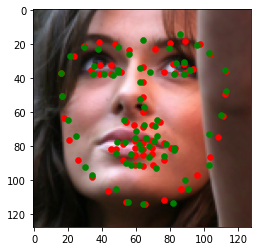

In [19]:
plt.imshow(mpimg.imread('helen/preprocessed_train_img/figure0.png'))
plt.scatter(mean_train_landmarks[:,0],mean_train_landmarks[:,1],color="red",linewidths=0.5)
plt.scatter(mean_train_landmarks[:,0]+train_pred[0,:,0],mean_train_landmarks[:,1]+train_pred[0,:,1],color="green",linewidths=0.5)
plt.show()

<font size="3">**2. What can we conclude ?**</font>

The results are not good. It would eventually work better with another size of patch. 

<font size="3">**3. Why this prediction error is not relevant to evaluate our methods ?**</font>

This prediction is not relevant to evaluate our methods because it is biased. Indeed, it is computed from an image that was used to train the model. We have to use a test set.

<font size="3">**4. Compute the prediction error on the test set and display s0 the initial position of the
model (in red) and s0 + δs the displaced landmarks (in green) for the 5 first images of the
test set.**</font>

In [24]:
if(os.path.exists('backup/points_test.pkl')):
    with open('backup/points_test.pkl', 'rb') as file:
        points_test = pickle.load(file)
else:
    points_test = np.empty((136,0))
    for i in range(len(test_landmark_paths)):
        print("\r" + str(i) + "/" + str(len(test_landmark_paths)),end='')
        pts = np.loadtxt('helen/preprocessed_test_img/figure' + str(i) + '.txt')
        pts = pts.reshape((136,1))
        points_test = np.append(points_test,pts,axis=1)
        
        # we choose to not take into account the augmented data to make PCA computationnally tractable with our computers
        """
        for j in range(10):
            pts = np.loadtxt('helen/preprocessed_test_img/figure' + str(i) + '_' + str(j) + '.txt')
            pts = pts.reshape((136,1))
            points = np.append(points,pts,axis=1)
        """
    
    with open('backup/points_test.pkl', 'wb') as file:
        pickle.dump(points_test, file)

In [26]:
X0_tilde_test = np.matmul(test_eigenvectors,X0_test)

mean_test_landmarks_ = mean_test_landmarks.reshape((136,1))
mean_test_landmarks_ = np.repeat(mean_test_landmarks_,X0_tilde_test.shape[1], axis = 1)

X0_tilde_test = np.concatenate([X0_tilde_test, np.ones((1,X0_tilde_test.shape[1]))], axis=0)

delta_test = (points_test - mean_test_landmarks_)

reg_test = LinearRegression().fit(X0_tilde_test.T, delta_test.T)

In [27]:
print("mean absolute error on the train set =",np.mean(np.abs(delta_test - reg_test.predict(X0_tilde_test.T).T)))

mean absolute error on the train set = 1.575842465329888


In [28]:
print("score on the test set =",reg_test.score(X0_tilde_test.T, delta_test.T))

score on the test set = 0.9131359253303486


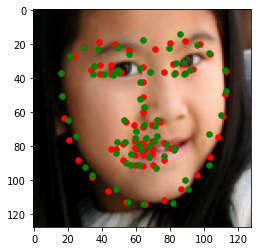

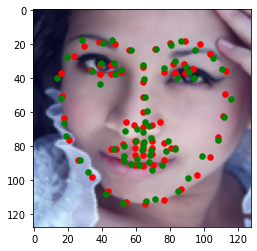

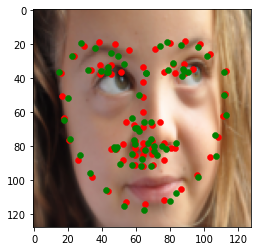

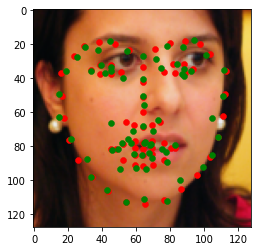

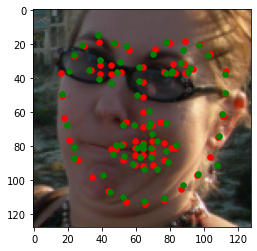

In [29]:
for i in range(5):
    plt.imshow(mpimg.imread('helen/preprocessed_test_img/figure' + str(i) + '.png'))
    plt.scatter(mean_train_landmarks[:,0],mean_train_landmarks[:,1],color="red",linewidths=0.5)
    plt.scatter(mean_train_landmarks[:,0]+train_pred[i,:,0],mean_train_landmarks[:,1]+train_pred[i,:,1],color="green",linewidths=0.5)
    plt.show()

<font size="3">**4. What can we conclude ?**</font>

The results are not good. It would probably work better with more data. In order to improve the performance we could also fully implement the cascade regression.